In [1]:
import os
import sys
import zipfile
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
#extracting the zip file
zip_file = '/content/archive.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
#version of the libraries used
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("torch version :",torch.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)


Platform: win32
Python version: 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
---
torch version : 2.8.0+cpu
pandas version: 2.3.1
numpy version: 2.1.2


In [4]:
#dataset
train_dir=os.path.join('data','train')
test_dir=os.path.join('data','test')

In [5]:
target_var=os.listdir(train_dir)
print(target_var)

['happy', 'fearful', 'surprised', 'neutral', 'sad', 'disgusted', 'angry']


In [6]:

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

else:
    print("gpu is not availale using cpu instead ")

GPU Name: Tesla T4


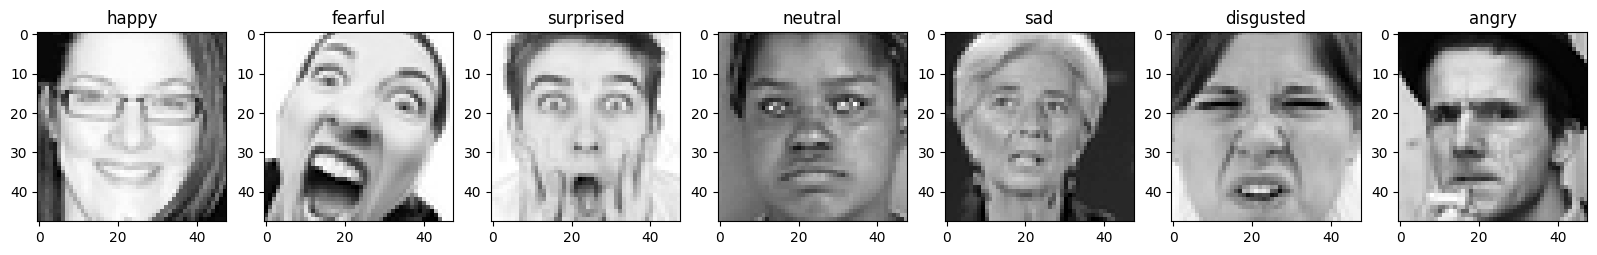

In [7]:
fig, axes=plt.subplots(1,7,figsize=(20,8))
for i in range (len(target_var)):

    dir_path=os.path.join(train_dir,target_var[i])
    im_1=os.path.join(dir_path,os.listdir(dir_path)[1])
    img=Image.open(im_1)
    axes[i].imshow(img,cmap='gray')
    axes[i].set_title(target_var[i])
plt.show()

## Class distriution

In [8]:
lables=[]
counts=[]

for folder in os.listdir(train_dir):
    folder_path=os.path.join(train_dir,folder)
    if os.path.isdir(folder_path):
        lables.append(folder)
        counts.append(len(os.listdir(folder_path)))

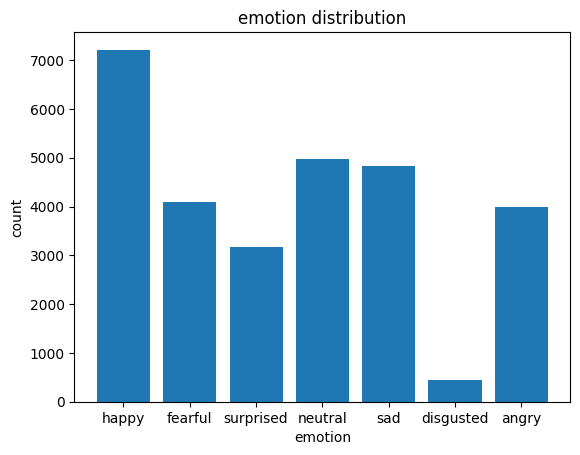

In [9]:
plt.bar(lables,counts)
plt.xlabel('emotion')
plt.ylabel('count')
plt.title('emotion distribution')
plt.show()

## Preprocessing

In [10]:
def get_mean_std(loader):
    channels_sum,channels_ss, num_batches =0, 0 ,0
    for data,_ in loader:
        channels_sum += torch.mean(data,dim=[0,2,3])
        channels_ss +=torch.mean(data ** 2,dim=[0,2,3])
        num_batches+=1
    mean=channels_sum/num_batches
    std=(channels_ss/num_batches-mean **2) ** 0.5

    return mean, std

In [11]:
#data preprocessing
transform_train=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),

    transforms.RandomRotation(10),
    transforms.Resize((48,48)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((48,48),scale=(0.8,1.0)),
    transforms.ToTensor(),

])


transform_test=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),

])


In [12]:
train_dataset=datasets.ImageFolder(root=train_dir,transform=transform_train)
test_dataset=datasets.ImageFolder(root=test_dir,transform=transform_test)

In [13]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [14]:
mean,std=get_mean_std(iter(train_loader))

In [15]:
mean_test,std_test=get_mean_std(iter(test_loader))

In [ ]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [16]:
transform_norm_train=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((48,48),scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)

])

transform_norm_test=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test,std=std_test)

])

In [17]:
train_dataset_norm=datasets.ImageFolder(root=train_dir,transform=transform_norm_train)
test_dataset_norm=datasets.ImageFolder(root=test_dir,transform=transform_norm_test)

In [18]:
train_loader=DataLoader(train_dataset_norm,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset_norm,batch_size=32,shuffle=False)

In [19]:
get_mean_std(iter(train_loader))

(tensor([3.4800e-05]), tensor([1.0000]))

In [20]:
sample=next(iter(test_loader))[0]
print(sample.shape)

torch.Size([32, 1, 48, 48])


In [21]:
print(train_dataset.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [39]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cpu'):


    # Move model to the proper device
    model.to(device)

    # Storage for metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)


        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

    return train_losses, val_losses, train_accs, val_accs





In [ ]:
def validate(model, val_loader, criterion, device='cpu'):

    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Predictions
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute mean loss & accuracy
    val_loss /= len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc*100:.2f}%")
    return val_loss, val_acc

In [43]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


   nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),



    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(in_features=288, out_features=64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64,7)


)


In [44]:
model1(sample).shape

torch.Size([32, 7])

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
train_loss,train_acc=train_and_validate(model1,train_loader,test_loader,criterion,optimizer,num_epochs=100,device=device)

Epoch [1/100] | Train Loss: 1.1673, Acc: 56.19% | Val Loss: 1.1031, Acc: 58.89%
Epoch [2/100] | Train Loss: 1.1646, Acc: 56.12% | Val Loss: 1.0881, Acc: 58.58%
Epoch [3/100] | Train Loss: 1.1660, Acc: 56.06% | Val Loss: 1.0913, Acc: 58.23%
Epoch [4/100] | Train Loss: 1.1631, Acc: 56.41% | Val Loss: 1.0900, Acc: 58.79%
Epoch [5/100] | Train Loss: 1.1681, Acc: 56.31% | Val Loss: 1.0988, Acc: 58.62%
Epoch [6/100] | Train Loss: 1.1626, Acc: 56.60% | Val Loss: 1.0985, Acc: 57.79%
Epoch [7/100] | Train Loss: 1.1677, Acc: 56.63% | Val Loss: 1.0858, Acc: 59.01%
Epoch [8/100] | Train Loss: 1.1651, Acc: 56.38% | Val Loss: 1.0872, Acc: 58.93%
Epoch [9/100] | Train Loss: 1.1582, Acc: 56.67% | Val Loss: 1.0804, Acc: 59.26%
Epoch [10/100] | Train Loss: 1.1614, Acc: 56.74% | Val Loss: 1.1041, Acc: 58.54%
Epoch [11/100] | Train Loss: 1.1623, Acc: 56.56% | Val Loss: 1.0759, Acc: 59.25%
Epoch [12/100] | Train Loss: 1.1613, Acc: 56.78% | Val Loss: 1.0798, Acc: 58.86%
Epoch [13/100] | Train Loss: 1.1650, 

NameError: name 'train_loss' is not defined

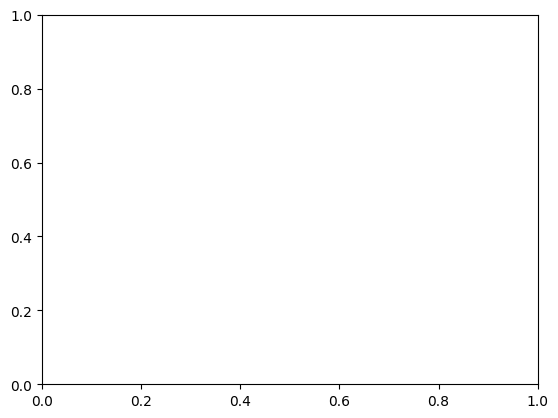

In [47]:
epoches=np.arange(1,31)


fig,ax1=plt.subplots()


ax1.plot(epoches,train_loss,label='loss')
ax1.set_xlabel('epoches')
ax1.set_ylabel('value')
ax1.set_ylabel('loss',color='b')


ax2=ax1.twinx()
ax2.plot(epoches,train_acc,label='accuracy')
ax2.set_ylabel('accuracy',color='b')

plt.title('accuracy and loss over epoches ')
plt.show()


In [ ]:
torch.save(model1.state_dict(),"models/modelv6.pth")

In [ ]:
#load the model
model1.load_state_dict(torch.load("models/modelv6.pth"))

<All keys matched successfully>

In [ ]:
model1.eval()
test_loss=0
correct=0
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs ,labels in test_loader :
        output=model1(inputs)
        loss=criterion(output,labels)
        test_loss +=loss.item()
        _, predicted=torch.max(output,1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())



In [ ]:
accuracy=accuracy_score(y_true,y_pred)
print(accuracy)

0.5600445806631373


## VGG6-like model definition for emotion detection

In [ ]:

import torch.nn as nn
class VGG6(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),  # Adjust if input size changes
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGG6(num_classes=len(train_dataset.classes)).to(device)
print(model)

KeyboardInterrupt: 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch 1 | Loss: 1.7496 | Accuracy: 28.16%
Epoch 2 | Loss: 1.5108 | Accuracy: 41.02%
Epoch 3 | Loss: 1.3822 | Accuracy: 46.73%


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),"models/modelvgg6_like.pth")

In [ ]:
# testing on the test set
model.eval()
test_loss=0
correct=0
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs ,labels in test_loader :
        output=model(inputs)
        loss=criterion(output,labels)
        test_loss +=loss.item()
        _, predicted=torch.max(output,1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy=accuracy_score(y_true,y_pred)

print(accuracy)

print(classification_report(y_true,y_pred,target_names=train_dataset.classes))

0.5798272499303427
              precision    recall  f1-score   support

       angry       0.48      0.53      0.50       958
   disgusted       0.66      0.40      0.49       111
     fearful       0.41      0.38      0.40      1024
       happy       0.78      0.80      0.79      1774
     neutral       0.54      0.49      0.52      1233
         sad       0.45      0.45      0.45      1247
   surprised       0.71      0.74      0.73       831

    accuracy                           0.58      7178
   macro avg       0.57      0.54      0.55      7178
weighted avg       0.58      0.58      0.58      7178



In [29]:
from torchvision import models
import torch.nn as nn

# Load VGG16 model (pretrained or not)
model = models.vgg16(pretrained=True)

# Modify the classifier for  number of classes ( 7 for emotion detection)
model.features[0]=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 7)

# Move to device
model=model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.2MB/s]


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
train_losses, train_accuracies = train_and_validate(model, train_loader,test_loader, criterion, optimizer, num_epochs=20,device=device)

Epoch [1/20] | Train Loss: 1.8133, Acc: 25.10% | Val Loss: 1.8161, Acc: 24.71%
Epoch [2/20] | Train Loss: 1.8133, Acc: 25.14% | Val Loss: 1.8158, Acc: 24.71%
Epoch [3/20] | Train Loss: 1.8127, Acc: 25.13% | Val Loss: 1.8163, Acc: 24.71%
Epoch [4/20] | Train Loss: 1.8128, Acc: 25.13% | Val Loss: 1.8155, Acc: 24.71%
Epoch [5/20] | Train Loss: 1.8119, Acc: 25.13% | Val Loss: 1.8169, Acc: 24.71%
Epoch [6/20] | Train Loss: 1.8120, Acc: 25.13% | Val Loss: 1.8141, Acc: 24.71%


KeyboardInterrupt: 